In [1]:
import os
from classification_models.tfkeras import Classifiers

# Import the ResNet34 model
ResNet34, preprocess_input = Classifiers.get('resnet34')

In [2]:
# Run only for training!
import glob
import math
import datetime
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
tfpl = tfp.layers
tfk = tf.keras
tfkl = tf.keras.layers


# Change parameters here...
log_dir = "logs/"
os.makedirs(log_dir, exist_ok=True)
data_dir = 'data/' # Change
sizex = 500
sizey = 500
sizez = 3
rand_seed = 666
num_datasets = -1
batch_size = 128
nb_epochs = 10
validation_ratio = 0.1

In [3]:
# Collect all the .npz files
numpy_datasets = glob.glob(data_dir+'dataset*')

In [4]:
# load the data into a dictionary from npz files
data_dict = {}
for dataset in numpy_datasets[:num_datasets]:
    with np.load(dataset) as data:
        if 'x_dust' in data_dict.keys():
            data_dict['x_dust']   = np.append( data_dict['x_dust'], data['x_dust'],axis=0)
            data_dict['x_nodust'] = np.append( data_dict['x_nodust'], data['x_nodust'],axis=0)
            data_dict['y']        = np.append( data_dict['y'], data['y'],axis=0)
            data_dict['ids']      = np.append( data_dict['ids'], data['id'],axis=0)
        else:
            data_dict['x_dust']   = data['x_dust']
            data_dict['x_nodust'] = data['x_nodust']
            data_dict['y']        = data['y']
            data_dict['ids']      = data['id']

In [5]:
# check the shape of the dictionary (100 images of 500x500x3 = 4 files of 25 images)
data_dict['x_dust'].shape

(895, 500, 500, 3)

In [6]:
# Normalice the angular momentum
from sklearn.preprocessing import normalize

# Compute the angles from the x,y,z labels
# theta = np.arctan(np.sqrt(x**2 + y**2)/z)
# phi = np.arctan(y/x)
def cart_to_esf(xyz):
    angles = np.empty( (len(xyz),2) )
    angles[:,0] = np.arctan2(np.sqrt(xyz[:,0]**2 + xyz[:,1]**2),xyz[:,2]) *180/np.pi #theta angle in degrees
    angles[:,1] = np.arctan2(xyz[:,1],xyz[:,0]) * 180/np.pi #phi angle in degrees
    return angles

# Define the function to go back to cartisian cordinates
def esf_to_cart(angles):
    xyz = np.empty( (len(angles),3) )
    ang_rad = angles*np.pi/180
    xyz[:,0] = np.sin(ang_rad[:,0])*np.cos(ang_rad[:,1])
    xyz[:,1] = np.sin(ang_rad[:,0])*np.sin(ang_rad[:,1])
    xyz[:,2] = np.cos(ang_rad[:,0])
    return xyz

#break the degeneracy of the solutions restricting the solution to 1 sector
def break_degeneracy(angles):
    ang_norm = angles
    for i in range(len(angles)):
        if ang_norm[:,1][i] < 0:
            ang_norm[:,1][i] = (ang_norm[:,1][i] + 180)
    return ang_norm

#map the solution to be between [0,1]
def map_to_1(angles, max = 180 ):
    ang_norm = angles/max
    return ang_norm

def map_to_180(ang_norm):
  angle = ang_norm*180
  return angle


'''data_dict['y_norm'] = normalize(data_dict['y'], axis=1)
data_dict['y_angle'] = cart_to_esf(data_dict['y_norm'])
data_dict['y_ang'] = break_degeneracy(data_dict['y_angle'])
data_dict['y_ang_norm'] = map_to_1(data_dict['y_ang'])
data_dict['y_xyz_nd'] = esf_to_cart(data_dict['y_ang'])
data_dict['y_xyz']   = esf_to_cart(data_dict['y_angle'])'''

# computing the normaliced angle and the come back to cartesian to check the conversion
data_dict['y'] = normalize(data_dict['y'], axis=1)
data_dict['y_angle'] = cart_to_esf(normalize(data_dict['y'], axis=1))
data_dict['y_xyz_nd']= esf_to_cart(data_dict['y_angle'])
data_dict['y_angle'] = map_to_1(data_dict['y_angle'])

In [7]:
# check the shape of our dictionary in te labels entry
print(data_dict['y_angle'].shape)

(895, 2)


In [8]:
# separate in batches and shuffle the data with a fixed seed
#dataset = dataset.batch(batch_size)
#dataset = dataset.shuffle(10, seed=123)
AUTO = tf.data.experimental.AUTOTUNE

In [12]:
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

# functions to visualice the data 
def viz(ds):
    elem = ds.take(1)
    for e in elem:
        img = e['x_nodust'][:,:,:]
        fig, ax = plt.subplots(figsize=(5,5))
        im = ax.imshow(img, cmap='gray', vmin=0, vmax=255,origin='lower')
        ax.arrow(250,250,100*e['y_xyz_nd'][0],100*e['y_xyz_nd'][1], head_width=7, head_length=10, fc='g', ec='g')
        ax.arrow(250,250,100*e['y'][0],100*e['y'][1], head_width=7, head_length=10, fc='r', ec='r')
        #display(Markdown("#### **Label:** {}".format(e['y_norm'])))
        display(Markdown("#### **angle:** {}".format(e['y'])))
        display(Markdown("#### **inverse:** {}".format(e['y_xyz_nd'])))
        print(e['ids'])
        plt.show()
        break

def viz_batch(ds, idx):
    elem = ds.take(idx) # get first batch
    for e in elem:
        img = e['x_nodust'][idx, :, :,:]
        fig, ax = plt.subplots(figsize=(5,5))
        im = ax.imshow(img, cmap='gray', vmin=0, vmax=255, origin='lower')
        ax.arrow(250,250,100*e['y_xyz_nd'][0,0],100*e['y_xyz_nd'][0,1], head_width=7, head_length=10, fc='g', ec='g')
        ax.arrow(250,250,100*e['y'][0,0],100*e['y'][0,1], head_width=7, head_length=10, fc='r', ec='r')
        #display(Markdown("#### **Label:** {}".format(e['y_norm'][idx])))
        display(Markdown("#### **angle:** {}".format(e['y'][idx])))
        display(Markdown("#### **inverse:** {}".format(e['y_xyz_nd'][idx])))
        print(e['ids'][idx])
        plt.show()
        break
        
# create the dataset from the dictionary and see the size and type
dataset = tf.data.Dataset.from_tensor_slices(data_dict)
print(dataset)

<TensorSliceDataset shapes: {x_dust: (500, 500, 3), x_nodust: (500, 500, 3), y: (3,), ids: (), y_angle: (2,), y_xyz_nd: (3,)}, types: {x_dust: tf.float64, x_nodust: tf.float64, y: tf.float64, ids: tf.string, y_angle: tf.float64, y_xyz_nd: tf.float64}>


#### **angle:** [0.73639    0.0919113  0.67028507]

#### **inverse:** [0.73639    0.0919113  0.67028507]

tf.Tensor(b'g5.38e11_x73_y33_z282', shape=(), dtype=string)


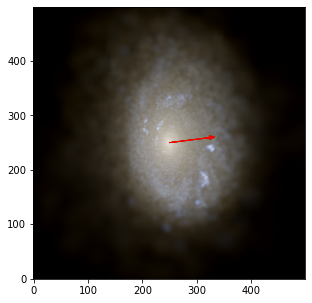

#### **angle:** [-0.31817019 -0.92758584  0.19583725]

#### **inverse:** [-0.31817019 -0.92758584  0.19583725]

tf.Tensor(b'g3.59e11_x181_y198_z9', shape=(), dtype=string)


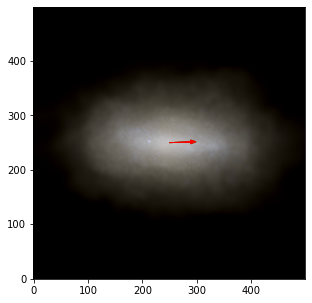

#### **angle:** [-0.24828037 -0.89546248  0.36946421]

#### **inverse:** [-0.24828037 -0.89546248  0.36946421]

tf.Tensor(b'g1.92e12_x192_y82_z333', shape=(), dtype=string)


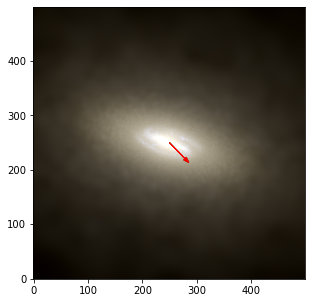

In [13]:
# visualice the data
viz(dataset)
real_dataset = dataset.batch(batch_size).shuffle(10, seed=rand_seed)
for i in range(1,3):
    viz_batch(real_dataset, i) # select any index within the batch, e.g. 2

In [11]:
# defining the train and validation dataset from the existing dictionary, shufling and batching
ds_size = len(data_dict['y_angle'])

input_ds = (
    tf.data.Dataset.from_tensor_slices((data_dict['x_nodust'].astype(np.float32), data_dict['y_angle'].astype(np.float32)))
                    # Use seed to ensure we always have the same validation data set!
                   .shuffle(ds_size, seed = rand_seed, reshuffle_each_iteration = False)
)

val_size = math.floor(ds_size * validation_ratio)
validation_ds = ( input_ds.take(val_size).batch(batch_size) )
train_ds = ( input_ds.skip(val_size).shuffle(buffer_size=895, reshuffle_each_iteration=True).batch(batch_size) )

print(train_ds)
print(validation_ds)

<BatchDataset shapes: ((None, 500, 500, 3), (None, 2)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 500, 500, 3), (None, 2)), types: (tf.float32, tf.float32)>


In [3]:
%reload_ext tensorboard
%tensorboard --logdir {log_dir} --reload_multifile True --host 0.0.0.0 --port 6006

ERROR: Failed to launch TensorBoard (exited with 255).
Contents of stderr:
E0803 11:10:57.015882 47329840183296 program.py:311] TensorBoard could not bind to port 6006, it was already in use
ERROR: TensorBoard could not bind to port 6006, it was already in use

In [13]:
# Build model
base_model = ResNet34(input_shape=(sizey,sizex,3), weights='imagenet', include_top=False)

# redefine the output to be from tensorflow probability a PDF
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x_2 = tf.keras.layers.Dense(tfpl.IndependentNormal.params_size(3), activation=None)(x)
#tfpl.IndependentNormal(input_shape, tfd.Normal.mean),
output = tfpl.IndependentNormal(3, tfd.Normal.sample)(x_2)
model = tf.keras.models.Model(inputs=[base_model.input], outputs=[output])

# Use existing best weights if available...
snapshot_weights = 'best_weights_3params.hdf5'
if os.path.isfile(snapshot_weights):
    model.load_weights(snapshot_weights)

negloglik = lambda y, p_y: -p_y.log_prob(y)
    
model.compile(optimizer='SGD', loss=negloglik, metrics=['accuracy'])
# model.summary()

# For tensorboard
log_dir_s = log_dir + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
os.makedirs(log_dir_s, exist_ok=True)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir_s, histogram_freq=1, update_freq='batch', profile_batch=0)

# Checkpointing
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath=snapshot_weights,
                               monitor='val_accuracy',
                               verbose=1,
                               save_best_only=True)

callbacks = [
    tensorboard_callback,
    checkpointer
]

model.save('models/untrained.h5')

model.fit(
    train_ds,
    validation_data = validation_ds,
    epochs = nb_epochs,
    callbacks = callbacks,)
    # class_weight=class_weight)

model.save('models/trained.h5') # Not really needed as we have the weights already

Epoch 1/10
13/13 [==============================] - ETA: 0s - loss: 17.8004 - accuracy: 0.6079 
Epoch 00001: val_accuracy improved from -inf to 0.55056, saving model to best_weights.hdf5
13/13 [==============================] - 202s 16s/step - loss: 17.8004 - accuracy: 0.6079 - val_loss: 56.4660 - val_accuracy: 0.5506
Epoch 2/10
13/13 [==============================] - ETA: 0s - loss: 11.0039 - accuracy: 0.5943 
Epoch 00002: val_accuracy improved from 0.55056 to 0.61798, saving model to best_weights.hdf5
13/13 [==============================] - 200s 15s/step - loss: 11.0039 - accuracy: 0.5943 - val_loss: 44.6772 - val_accuracy: 0.6180
Epoch 3/10
13/13 [==============================] - ETA: 0s - loss: 10.6337 - accuracy: 0.6427 
Epoch 00003: val_accuracy improved from 0.61798 to 0.64045, saving model to best_weights.hdf5
13/13 [==============================] - 201s 15s/step - loss: 10.6337 - accuracy: 0.6427 - val_loss: 37.8182 - val_accuracy: 0.6404
Epoch 4/10
13/13 [================

In [14]:
domain = np.linspace(0,1,100)
val_ex, = validation_ds.take(1)
outputs = np.array([model.predict(val_ex)])

for i in range(len(domain)):
    outputs = np.append(outputs, [model.predict(val_ex)],axis=0)

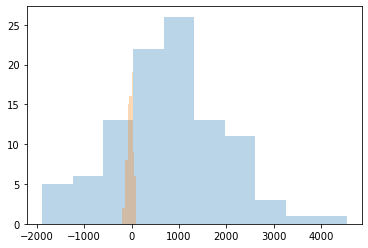

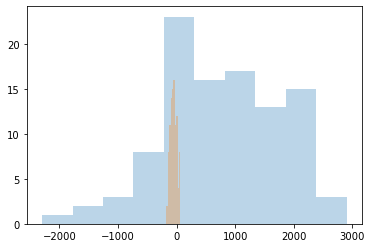

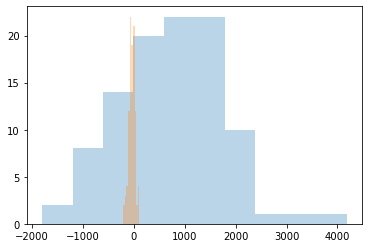

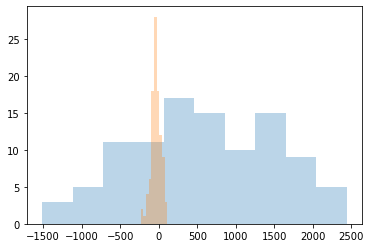

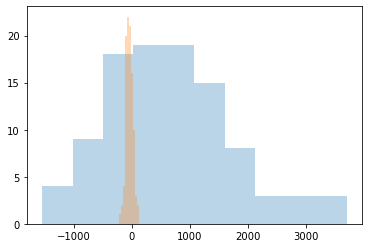

In [15]:
for i in range(5):
    plt.hist(np.array(outputs[:,i,0]),alpha=0.3)
    plt.hist(np.array(outputs[:,i,1]),alpha=0.3)
    plt.show()

In [16]:
means = np.mean(outputs,axis=0)
images, labels = val_ex[0], val_ex[1]

print(means)
print(labels)

[[806.50195  -36.256847]
 [750.43195  -53.70292 ]
 [716.8612   -36.569424]
 [588.55804  -38.348083]
 [645.96466  -49.315445]
 [825.3733   -29.62208 ]
 [658.58136  -38.01925 ]
 [824.4977   -46.434296]
 [875.5348   -45.47336 ]
 [727.02026  -41.077015]
 [372.26755  -25.692682]
 [744.869    -35.414116]
 [643.08057  -40.220074]
 [605.7342   -50.195724]
 [690.3197   -48.819332]
 [630.2657   -43.434826]
 [693.5088   -45.90299 ]
 [839.13654  -35.623276]
 [801.4127   -40.386368]
 [634.4797   -31.4999  ]
 [728.90393  -43.67978 ]
 [797.6598   -51.19312 ]
 [624.78033  -46.047195]
 [822.60394  -42.04516 ]
 [799.0752   -33.479015]
 [738.13336  -44.15621 ]
 [411.16953  -45.636242]
 [599.41516  -34.320415]
 [697.6323   -38.82556 ]
 [691.7842   -39.68304 ]
 [785.3693   -45.72541 ]
 [579.68115  -47.385704]
 [684.76697  -34.84686 ]
 [667.77496  -33.05473 ]
 [822.5483   -40.805866]
 [583.8158   -41.87289 ]
 [495.03604  -45.16033 ]
 [817.29504  -45.493855]
 [860.98987  -46.782776]
 [730.43054  -48.995335]


[[-0.84265351 -0.33552358  0.42114013]
 [ 0.02131403 -0.96649814 -0.25578719]
 [-0.61547321 -0.4136835   0.67086416]
 [-0.23350421  0.35924268 -0.90355992]
 [ 0.40160483 -0.9077701   0.12110718]
 [-0.33904734 -0.50253624 -0.79530138]
 [-0.34911361  0.1430781  -0.92609304]
 [ 0.93806309 -0.24427348  0.24569929]
 [-0.67324799  0.67891318 -0.29294041]
 [-0.636594   -0.06464829  0.76848465]
 [ 0.88915777 -0.45496514  0.04904288]
 [-0.73583055 -0.4918994   0.4653905 ]
 [-0.36582291 -0.2936551  -0.88314229]
 [ 0.33632055 -0.39548269 -0.85468239]
 [-0.84827811 -0.08442685 -0.52277756]
 [ 0.9483459  -0.31677258 -0.01718179]
 [-0.77722114  0.61038494 -0.15283194]
 [ 0.30317801 -0.76488388  0.5683623 ]
 [-0.64811254 -0.55281466 -0.52378064]
 [-0.70283109  0.69030213 -0.17178887]
 [ 0.46680319  0.76074618 -0.45095465]
 [-0.54101634  0.31896383  0.77817953]
 [ 0.98745912 -0.1578069  -0.0046319 ]
 [ 0.86710072 -0.36242247  0.3417401 ]
 [-0.15209092  0.16595967  0.97433347]
 [-0.36790246 -0.39514485

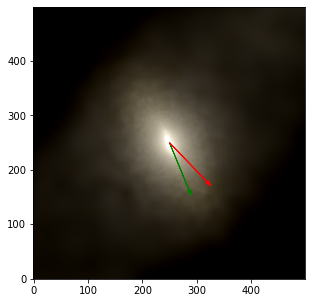

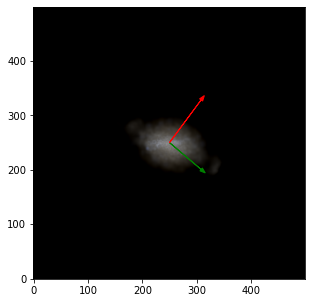

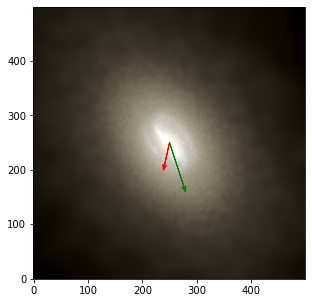

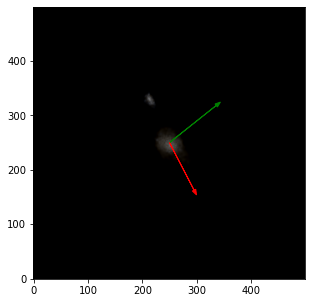

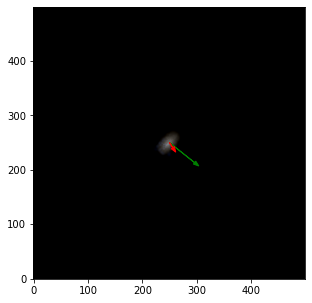

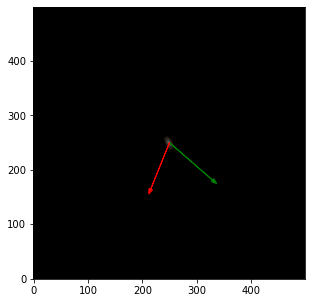

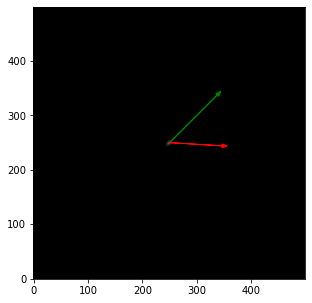

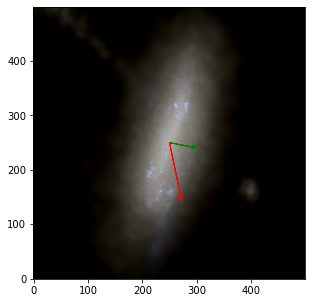

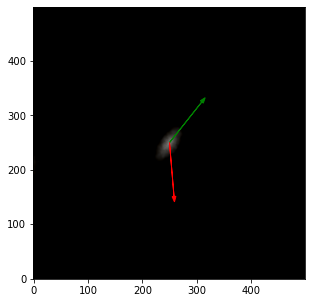

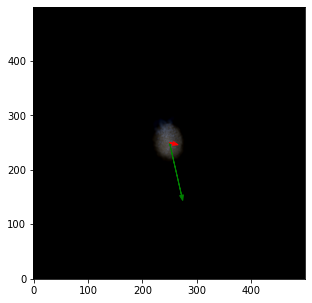

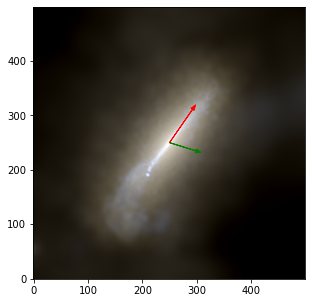

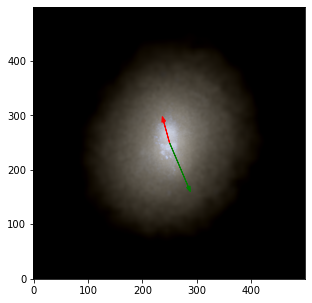

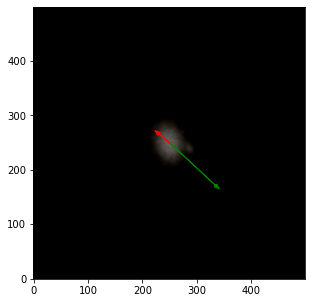

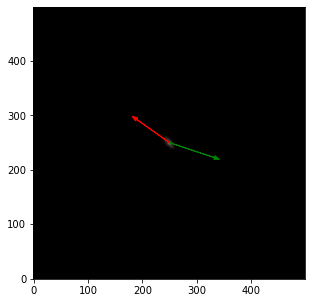

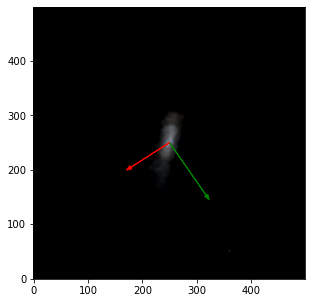

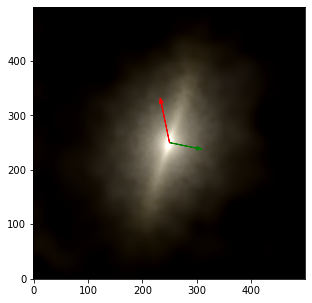

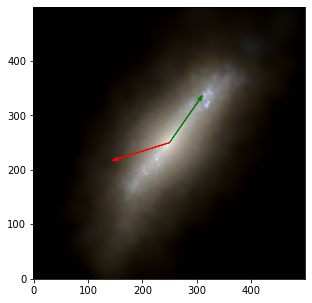

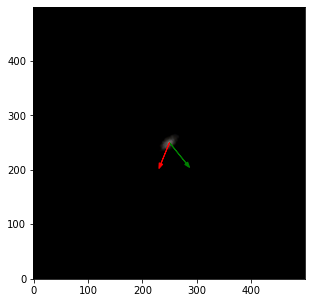

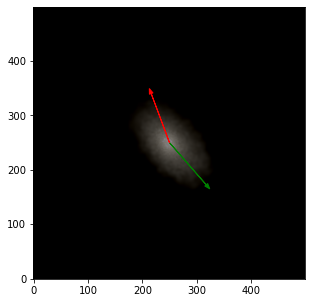

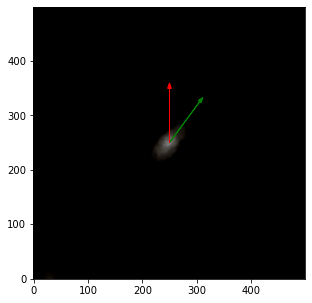

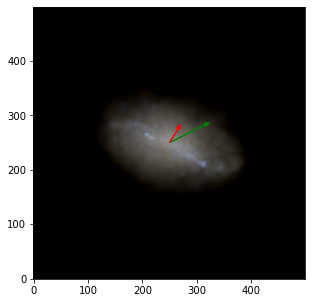

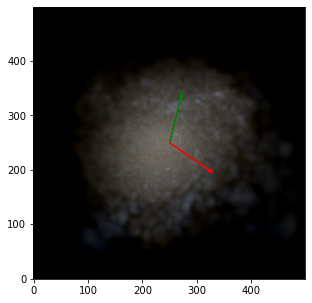

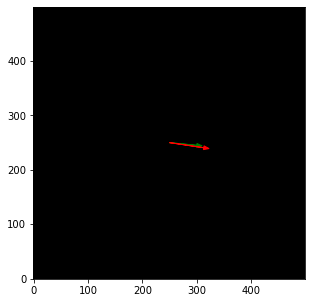

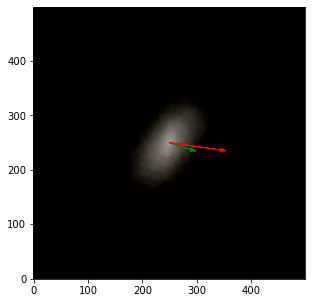

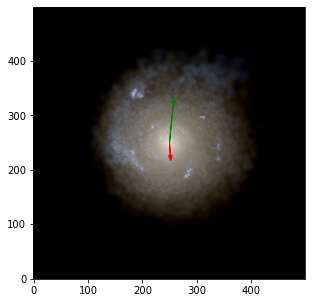

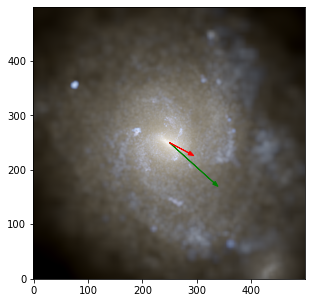

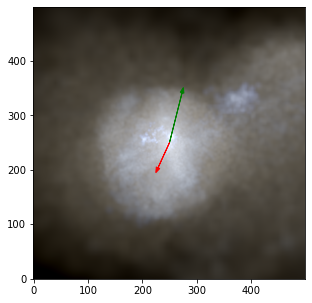

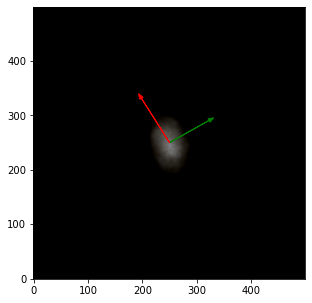

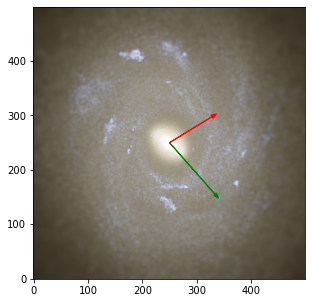

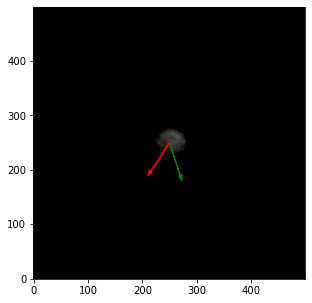

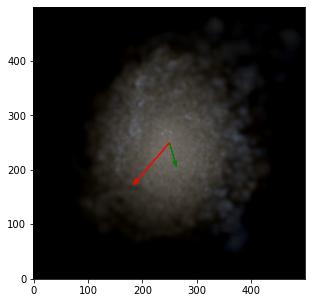

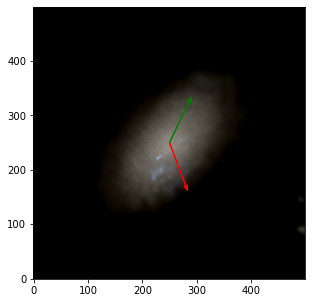

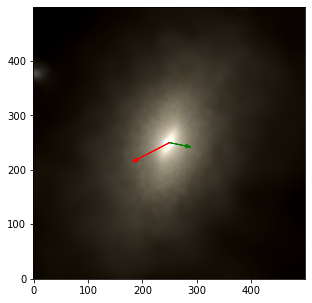

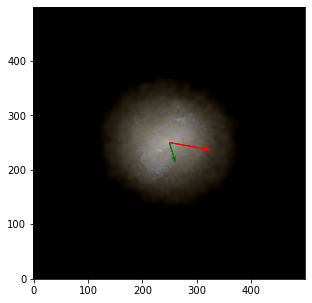

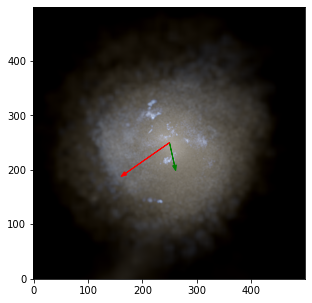

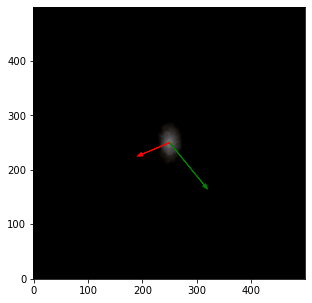

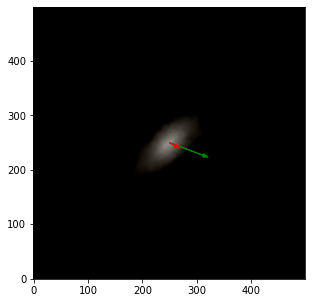

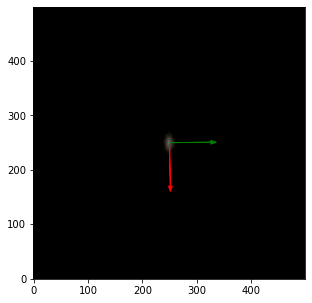

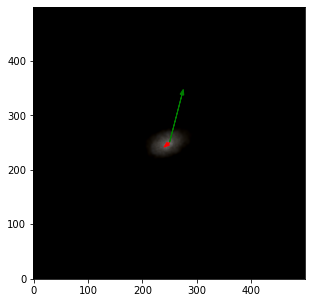

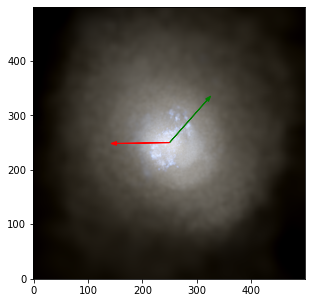

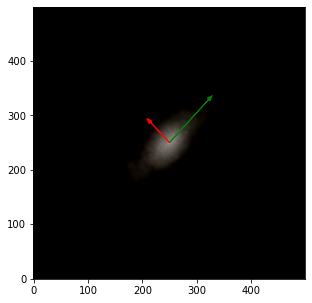

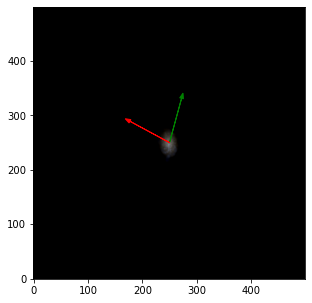

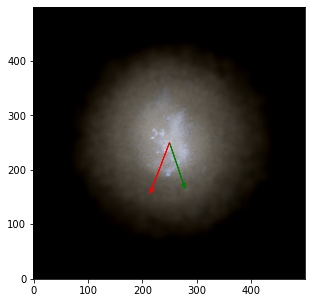

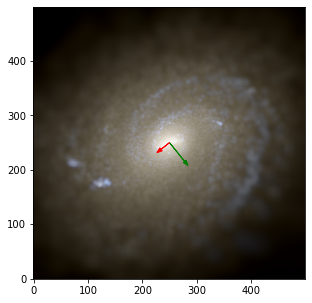

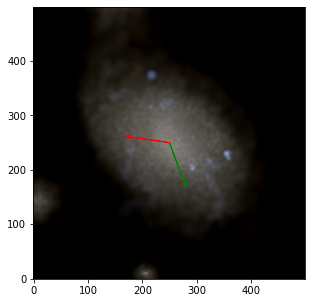

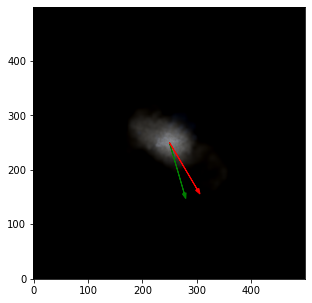

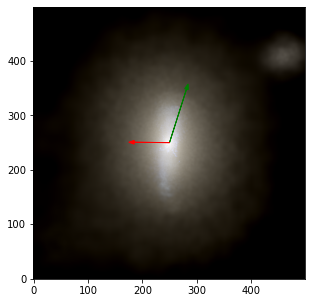

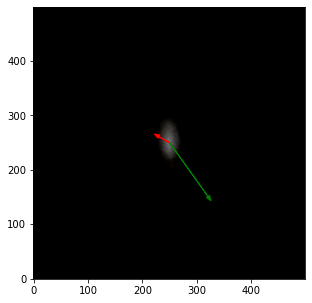

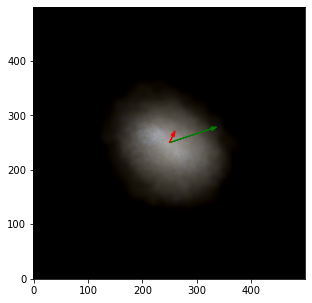

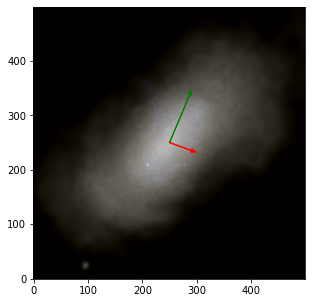

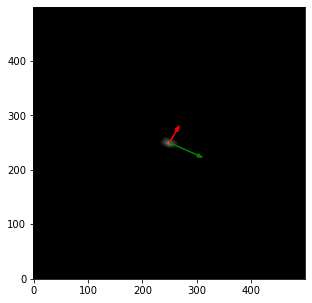

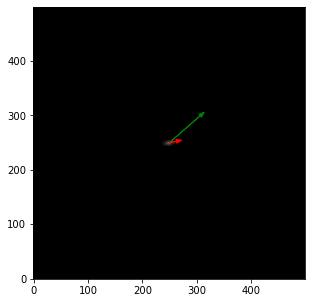

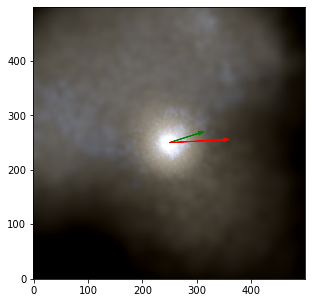

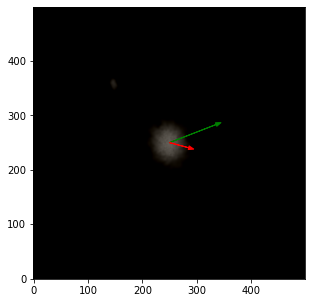

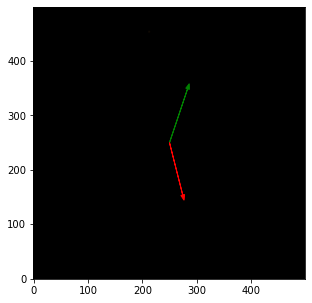

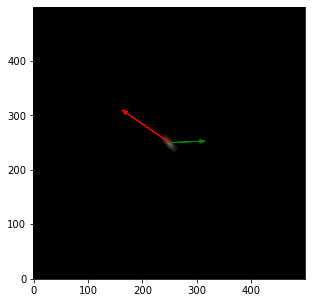

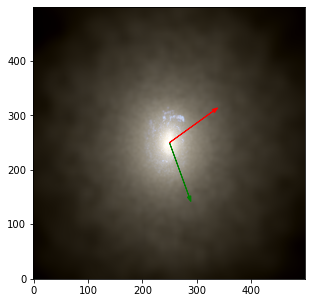

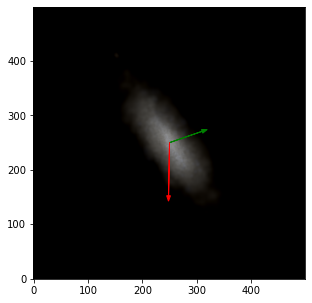

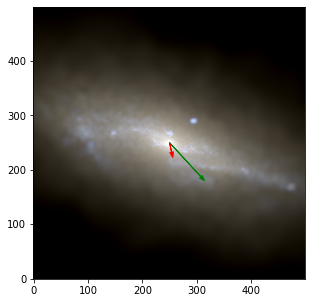

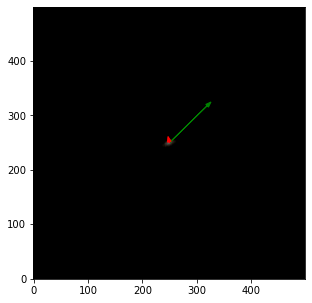

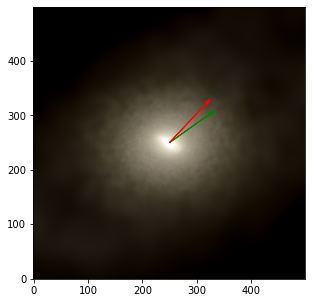

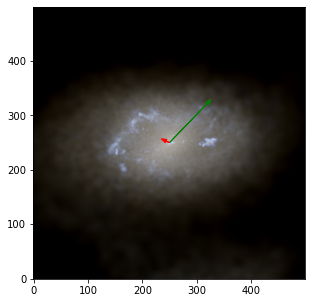

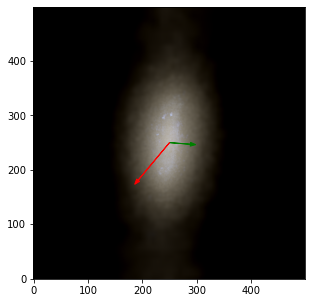

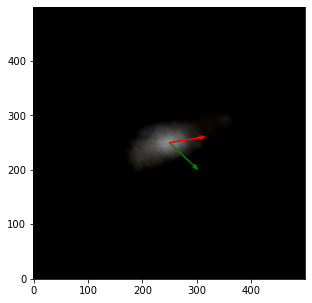

In [17]:
label = esf_to_cart(map_to_180(labels))
predi = esf_to_cart(map_to_180(means))

print(label)
print(predi)

for img,label,i in zip(images,labels,range(len(label))):
    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(img, cmap='gray', vmin=0, vmax=255,origin='lower')
    ax.arrow(250,250,100*label[0],100*label[1], head_width=7, head_length=10, fc='g', ec='g')
    ax.arrow(250,250,100*predi[i][0],100*predi[i][1], head_width=7, head_length=10, fc='r', ec='r')
    #display(Markdown("#### **Label:** {}".format(e['y_norm'])))
    plt.show()